# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [83]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [84]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [85]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [86]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균

cols = ['Income', 'Total_Spending', 'Age']

result = []

for col in cols:
    mean_val = df[col].mean()
    median_val = df[col].median()
    mode_val = df[col].mode()[0]
    trimmed_mean_val = stats.trim_mean(df[col], 0.05)
    
    result.append([col, mean_val, median_val, mode_val, trimmed_mean_val])

summary_df = pd.DataFrame(result, columns=['Variable', 'Mean', 'Median', 'Mode', '5% Trimmed Mean'])

print(summary_df)


         Variable          Mean   Median     Mode  5% Trimmed Mean
0          Income  51952.614043  51381.5  51381.5     51740.153426
1  Total_Spending    605.986583    396.5     46.0       561.119662
2             Age     55.101968     54.0     48.0        55.074975


In [87]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)

cols = ['Income', 'Total_Spending', 'Age']

result = []

for col in cols:
    variance = df[col].var(ddof=1)
    std_dev = df[col].std(ddof=1)
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    mean_val = df[col].mean()
    CV = (std_dev / mean_val) * 100
    
    result.append([col, variance, std_dev, iqr, CV])

dispersion_df = pd.DataFrame(result, columns=['Variable', 'Variance(ddof=1)', 'Std_Dev', 'IQR', 'CV(%)'])

print(dispersion_df)

         Variable  Variance(ddof=1)       Std_Dev       IQR      CV(%)
0          Income      4.584509e+08  21411.466851  32773.25  41.213454
1  Total_Spending      3.622417e+05    601.865156    976.50  99.319881
2             Age      1.369668e+02     11.703281     18.00  21.239315


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

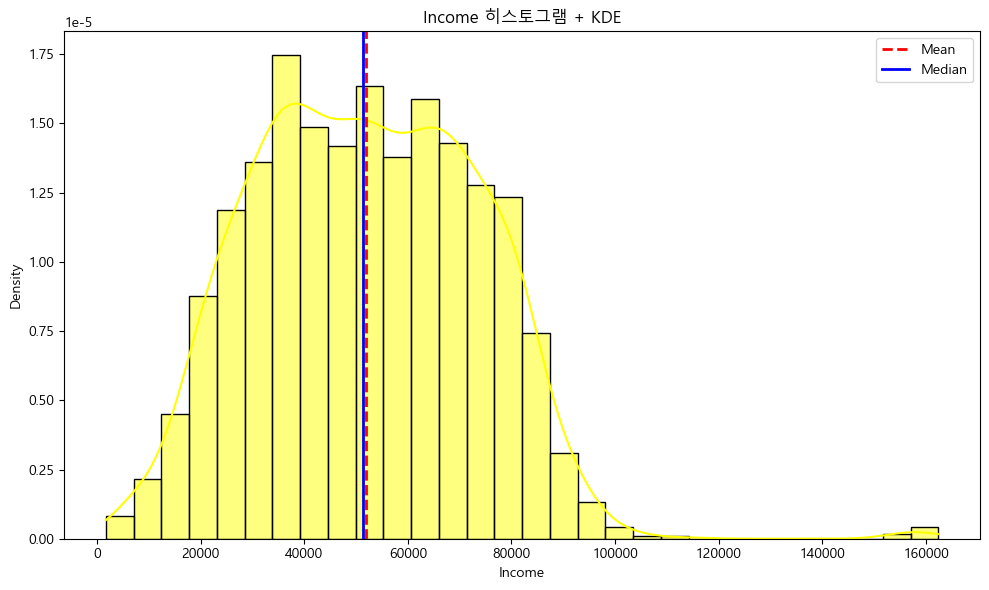

In [88]:
# TODO 1-2(a): Income 히스토그램 + KDE

mean_income = df['Income'].mean()
median_income = df['Income'].median()

plt.figure(figsize=(10,6))

sns.histplot(df['Income'], bins=30, kde=True, stat='density',color='yellow')

plt.axvline(mean_income, color='red', linestyle='--', linewidth=2, label=f'Mean')

plt.axvline(median_income, color='blue', linestyle='-', linewidth=2, label=f'Median')

plt.title('Income 히스토그램 + KDE')
plt.xlabel('Income')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

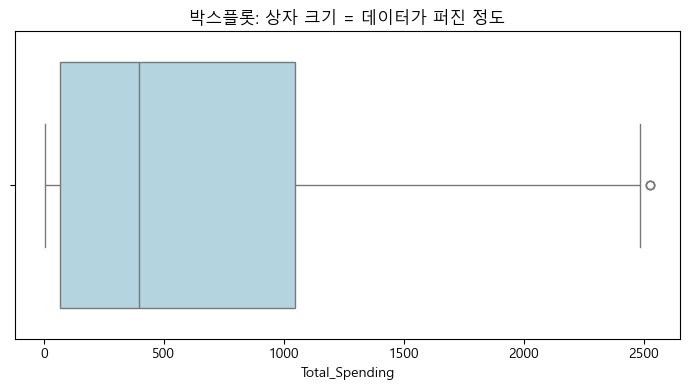

In [89]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치

Q1 = df['Total_Spending'].quantile(0.25)
Q3 = df['Total_Spending'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Total_Spending'] < lower_bound) | (df['Total_Spending'] > upper_bound)]

plt.figure(figsize=(7,4))
sns.boxplot(x=df['Total_Spending'], color='lightblue')
plt.title('박스플롯: 상자 크기 = 데이터가 퍼진 정도')
plt.xlabel('Total_Spending')
plt.tight_layout()
plt.show()

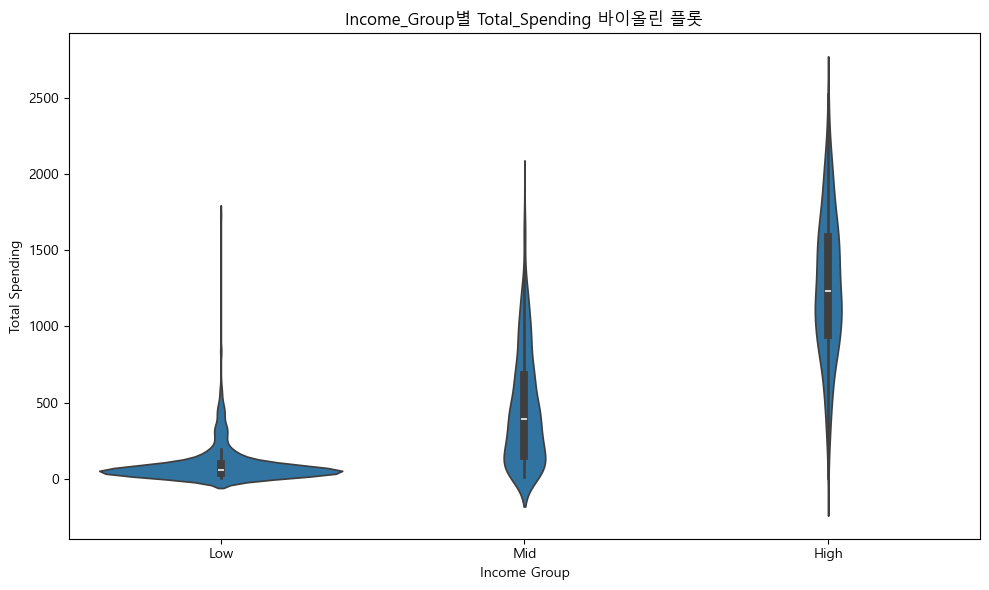

In [90]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯

plt.figure(figsize=(10,6))

sns.violinplot( x='Income_Group', y='Total_Spending', data=df, inner='box')

plt.title('Income_Group별 Total_Spending 바이올린 플롯')
plt.xlabel('Income Group')
plt.ylabel('Total Spending')
plt.tight_layout()
plt.show()

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [91]:
from scipy.stats import skew, kurtosis


spending_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'], COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력

spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

result = []

for col, name in zip(spending_cols, spending_names):
    skew_val = df[col].skew()
    kurt_val = df[col].kurt()
    
    result.append([name, skew_val, kurt_val])

skew_kurt = pd.DataFrame(result, columns=['Category', 'Skewness', 'Kurtosis'])

print(skew_kurt)

  Category  Skewness  Kurtosis
0    Wines  1.176036  0.600531
1   Fruits  2.104241  4.069754
2     Meat  2.085282  5.530136
3     Fish  1.919970  3.096020
4   Sweets  2.135674  4.372062
5     Gold  1.885136  3.558349


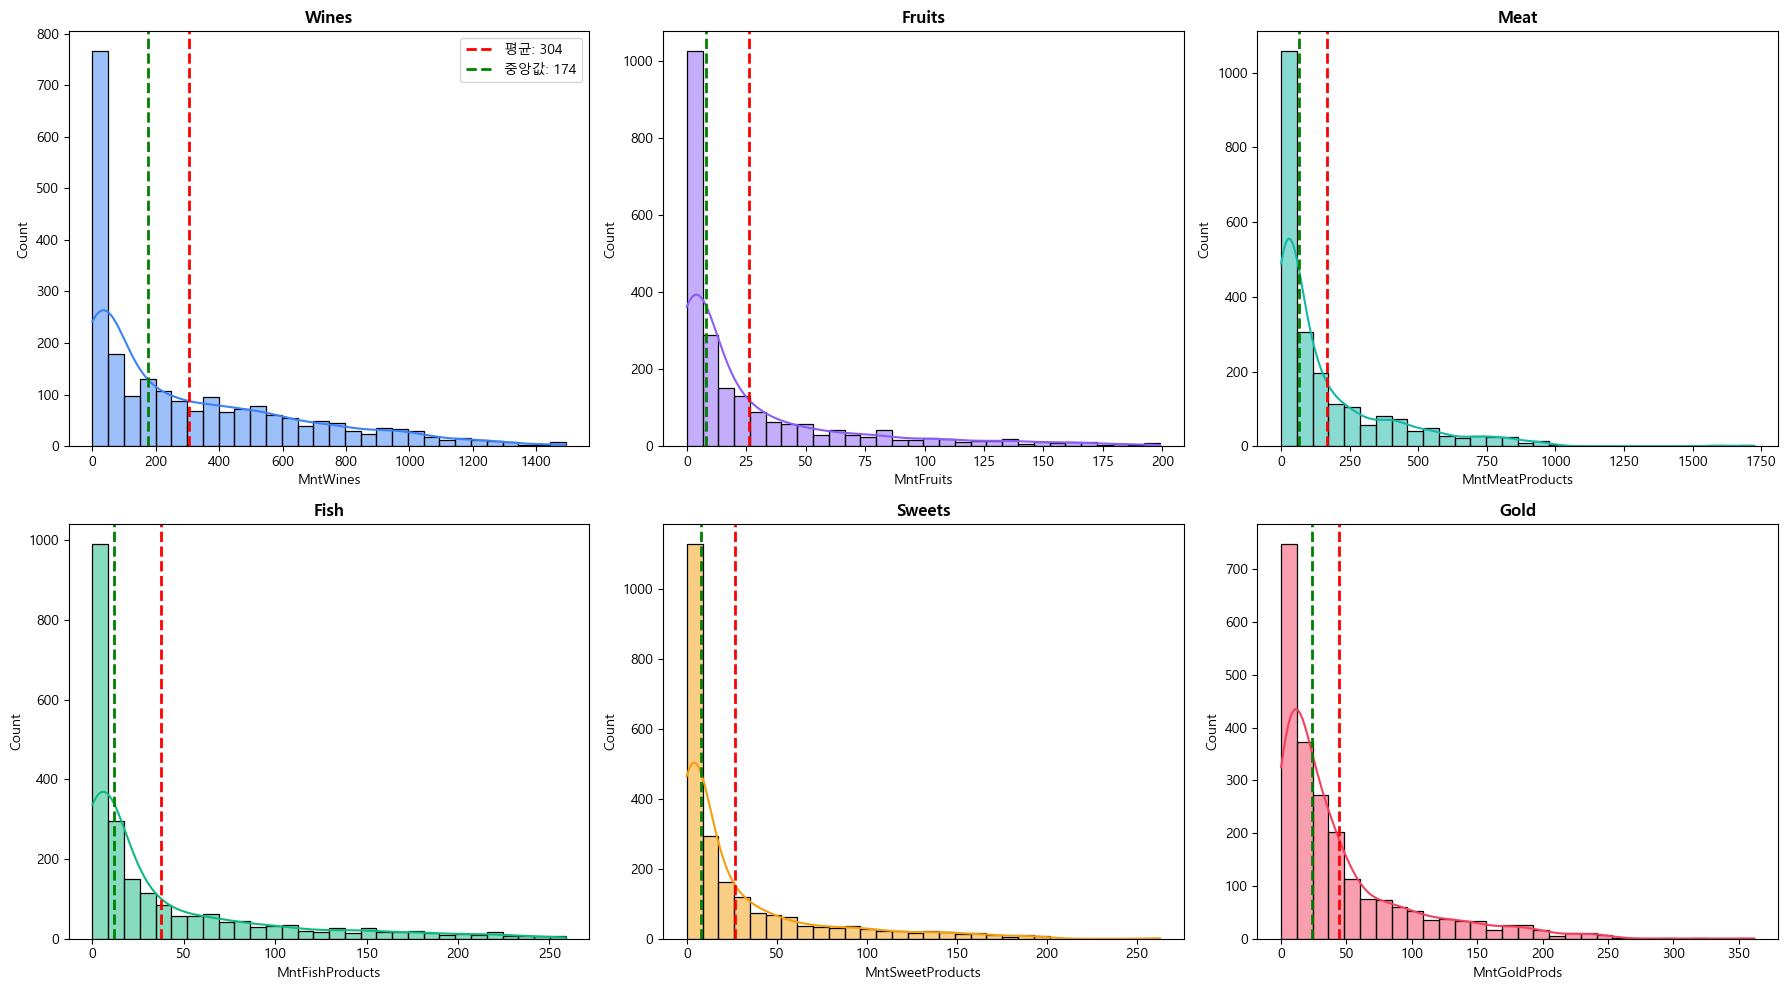

In [92]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# ------------------ 1. Wines ------------------
data = df['MntWines']
sns.histplot(data, bins=30, kde=True, color=hist_colors[0], edgecolor='black', ax=axes[0, 0])
axes[0, 0].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'평균: {data.mean():.0f}')
axes[0, 0].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'중앙값: {data.median():.0f}')
axes[0, 0].set_title(f"Wines", fontweight='bold')
axes[0, 0].legend()

# ------------------ 2. Fruits ------------------
data = df['MntFruits']
sns.histplot(data, bins=30, kde=True, color=hist_colors[1], edgecolor='black', ax=axes[0, 1])
axes[0, 1].axvline(data.mean(), color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(data.median(), color='green', linestyle='--', linewidth=2)
axes[0, 1].set_title(f"Fruits", fontweight='bold')

# ------------------ 3. Meat ------------------
data = df['MntMeatProducts']
sns.histplot(data, bins=30, kde=True, color=hist_colors[2], edgecolor='black', ax=axes[0, 2])
axes[0, 2].axvline(data.mean(), color='red', linestyle='--', linewidth=2)
axes[0, 2].axvline(data.median(), color='green', linestyle='--', linewidth=2)
axes[0, 2].set_title(f"Meat", fontweight='bold')

# ------------------ 4. Fish ------------------
data = df['MntFishProducts']
sns.histplot(data, bins=30, kde=True, color=hist_colors[3], edgecolor='black', ax=axes[1, 0])
axes[1, 0].axvline(data.mean(), color='red', linestyle='--', linewidth=2)
axes[1, 0].axvline(data.median(), color='green', linestyle='--', linewidth=2)
axes[1, 0].set_title(f"Fish", fontweight='bold')

# ------------------ 5. Sweets ------------------
data = df['MntSweetProducts']
sns.histplot(data, bins=30, kde=True, color=hist_colors[4], edgecolor='black', ax=axes[1, 1])
axes[1, 1].axvline(data.mean(), color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(data.median(), color='green', linestyle='--', linewidth=2)
axes[1, 1].set_title(f"Sweets", fontweight='bold')

# ------------------ 6. Gold ------------------
data = df['MntGoldProds']
sns.histplot(data, bins=30, kde=True, color=hist_colors[5], edgecolor='black', ax=axes[1, 2])
axes[1, 2].axvline(data.mean(), color='red', linestyle='--', linewidth=2)
axes[1, 2].axvline(data.median(), color='green', linestyle='--', linewidth=2)
axes[1, 2].set_title(f"Gold", fontweight='bold')

plt.tight_layout()
plt.show()

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [93]:
# TODO 1-4: 비즈니스 인사이트 정리

print("1. 고객 특성 요약")
print("평균 연령은 55.1세로 중장년층 중심의 고객 구조를 보인다.")
print("평균 소득은 51,953이고 소득 변동계수는 41.2%로 고객 간 소득 편차가 존재한다.")
print("평균 총 소비는 606.0이고 소비 변동계수는 99.3%로 매우 높은 소비 불균형을 보인다.")
print("")

print("2. 핵심 발견 사항")
print("소비 변동성(99.3%)이 소득 변동성(41.2%)보다 훨씬 높아 소비 행동의 차이가 크게 나타난다.")
print("모든 소비 카테고리에서 왜도 > 0으로 우측 꼬리 분포를 보여 헤비 소비자가 존재한다.")
print("첨도가 0보다 커서 소수 핵심 고객이 매출에 큰 영향을 미칠 가능성이 높다.")
print("연령 변동계수는 21.2%로 비교적 안정적이므로 소비 차이는 연령보다 소비 행동 특성에 의해 결정될 가능성이 크다.")
print("")

print("3. 후속 분석에서 검증할 가설")
print("소득이 높은 고객일수록 총 소비액이 유의하게 높을 것이라는 가설을 검증할 필요가 있다.")
print("캠페인 반응 고객은 평균 소비액이 더 높을 것이라는 가설을 설정할 수 있다.")
print("와인 및 육류 소비가 높은 고객은 상위 소비 그룹에 속할 확률이 높을 것이라는 가설을 설정할 수 있다.")

1. 고객 특성 요약
평균 연령은 55.1세로 중장년층 중심의 고객 구조를 보인다.
평균 소득은 51,953이고 소득 변동계수는 41.2%로 고객 간 소득 편차가 존재한다.
평균 총 소비는 606.0이고 소비 변동계수는 99.3%로 매우 높은 소비 불균형을 보인다.

2. 핵심 발견 사항
소비 변동성(99.3%)이 소득 변동성(41.2%)보다 훨씬 높아 소비 행동의 차이가 크게 나타난다.
모든 소비 카테고리에서 왜도 > 0으로 우측 꼬리 분포를 보여 헤비 소비자가 존재한다.
첨도가 0보다 커서 소수 핵심 고객이 매출에 큰 영향을 미칠 가능성이 높다.
연령 변동계수는 21.2%로 비교적 안정적이므로 소비 차이는 연령보다 소비 행동 특성에 의해 결정될 가능성이 크다.

3. 후속 분석에서 검증할 가설
소득이 높은 고객일수록 총 소비액이 유의하게 높을 것이라는 가설을 검증할 필요가 있다.
캠페인 반응 고객은 평균 소비액이 더 높을 것이라는 가설을 설정할 수 있다.
와인 및 육류 소비가 높은 고객은 상위 소비 그룹에 속할 확률이 높을 것이라는 가설을 설정할 수 있다.


---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [94]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10
from scipy.stats import binom

p = df['Response'].mean()
print(f"수락률 p = {p:.4f}")

prob_2 = binom.pmf(2, n_trial, p)
print(f"10명 중 정확히 2명이 수락할 확률 P(X=2) = {prob_2:.4f}")

prob_3 = 1 - binom.cdf(2, n_trial, p)
print(f"10명 중 3명 이상이 수락할 확률 P(X≥3) = {prob_3:.4f}")

수락률 p = 0.1494
10명 중 정확히 2명이 수락할 확률 P(X=2) = 0.2752
10명 중 3명 이상이 수락할 확률 P(X≥3) = 0.1782


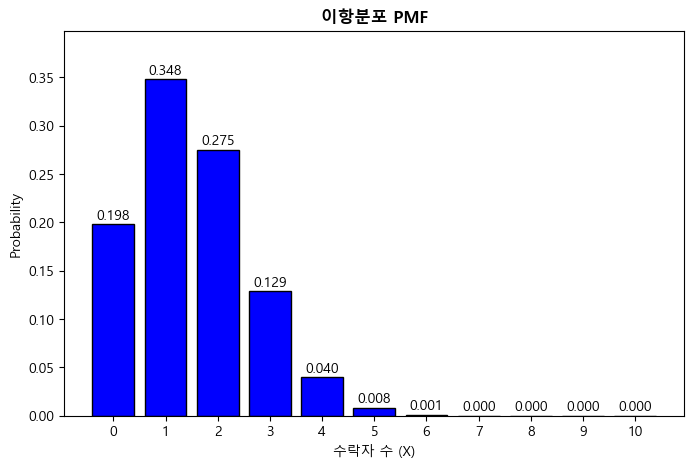

In [95]:
# TODO 2-1(c): 이항분포 PMF 시각화

x = np.arange(0, n_trial + 1)
pmf = binom.pmf(x, n_trial, p)

plt.figure(figsize=(8,5))
plt.bar(x, pmf, color='blue', edgecolor='black')


for i in range(len(x)):
    plt.text(x[i], pmf[i] + 0.005, f"{pmf[i]:.3f}", ha='center')
    # pmf[i] + 0.005 -> 막대 위에 조금 띄워서 표시

plt.title("이항분포 PMF", fontweight='bold')
plt.xlabel("수락자 수 (X)")
plt.ylabel("Probability")
plt.xticks(x)
plt.ylim(0, max(pmf) + 0.05)

plt.show()

In [96]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100

expected_value = n_campaign * p
print(f"100명 발송 시 기대 수락자 수 E(X) = {expected_value:.4f}명")

prob_15_or_more = 1 - binom.cdf(14, n_campaign, p)
print(f"P(X≥15) = {prob_15_or_more:.4f}")

k_min = binom.ppf(0.10, n_campaign, p)
print(f"90% 보장 최소 수락 수 : {int(k_min)}")

100명 발송 시 기대 수락자 수 E(X) = 14.9374명
P(X≥15) = 0.5358
90% 보장 최소 수락 수 : 10


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [102]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
from scipy.stats import poisson

web_visits = df['NumWebVisitsMonth']

lambda_hat = web_visits.mean()


sample_variance = web_visits.var(ddof=1)

print(f"람다 = {lambda_hat:.3f}")
print(f"표본 분산 = {sample_variance:.3f}")

print("평균과 분산 차이 큼 -> 포아송 분포 부적합")

람다 = 5.319
표본 분산 = 5.890
평균과 분산 차이 큼 -> 포아송 분포 부적합


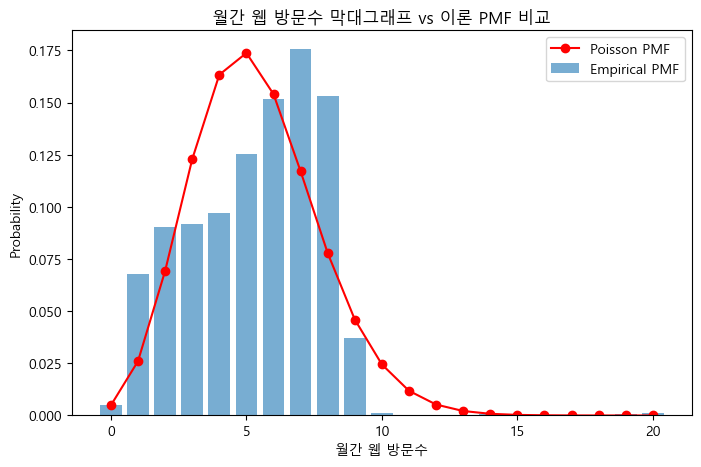

In [114]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
x = np.arange(0, web_visits.max() + 1)

empirical = web_visits.value_counts(normalize=True).sort_index()
theoretical = poisson.pmf(x, lambda_hat)

plt.figure(figsize=(8,5))

plt.bar(empirical.index, empirical.values, alpha=0.6, label="Empirical PMF")
plt.plot(x, theoretical, marker='o', color='red', label="Poisson PMF")

plt.title("월간 웹 방문수 막대그래프 vs 이론 PMF 비교")
plt.xlabel("월간 웹 방문수")
plt.ylabel("Probability")

plt.legend()
plt.show()

In [119]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10

prob_heavy = 1 - poisson.cdf(heavy_threshold - 1, lambda_hat)
print(f"월 10회 이상 방문 확률 P(X≥10) = {prob_heavy:.4f}")

k = poisson.ppf(0.95, lambda_hat)
print(f"P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k = {int(k)}")

월 10회 이상 방문 확률 P(X≥10) = 0.0449
P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k = 9


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [125]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교

from scipy.stats import norm

income = df['Income']


mu = income.mean()
sigma = income.std(ddof=1)

print(f"μ = {mu:.2f}")
print(f"σ = {sigma:.2f}")


prob_30000 = norm.cdf(30000, mu, sigma)
prob_80000 = 1 - norm.cdf(80000, mu, sigma)

print(f"P(Income < 30000) = {prob_30000:.4f}")
print(f"P(Income > 80000) = {prob_80000:.4f}")

emp_30000 = (income < 30000).mean()
emp_80000 = (income > 80000).mean()


top10 = norm.ppf(0.90, mu, sigma)
print(f"\n상위 10% 소득 기준값 (이론) = {top10:.2f}")

emp_top10 = income.quantile(0.90)
print(f"상위 10% 소득 기준값 (실측) = {emp_top10:.2f}")

μ = 51952.61
σ = 21411.47
P(Income < 30000) = 0.1526
P(Income > 80000) = 0.0951

상위 10% 소득 기준값 (이론) = 79392.51
상위 10% 소득 기준값 (실측) = 79747.50


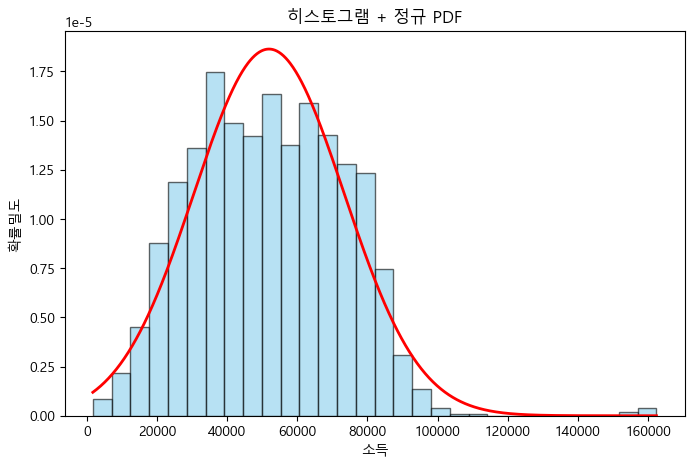

In [128]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기

x = np.linspace(income.min(), income.max(), 1000)

pdf = norm.pdf(x, mu, sigma)

plt.figure(figsize=(8,5))


plt.hist(income, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

plt.plot(x, pdf, color='red', linewidth=2)

plt.title("히스토그램 + 정규 PDF")
plt.xlabel("소득")
plt.ylabel("확률밀도")

plt.show()

In [135]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선

vip = norm.ppf(0.95, mu, sigma)
print(f"VIP(상위 5%) 기준선 = {vip}")

discount = norm.ppf(0.10, mu, sigma)
print(f"할인 대상(하위 10%) 기준선 = {discount}")


VIP(상위 5%) 기준선 = 87171.34295042677
할인 대상(하위 10%) 기준선 = 24512.715179993782


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [137]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE
from scipy.stats import t

x_bar = df['Total_Spending'].mean()
s = df['Total_Spending'].std(ddof=1)
n = len(df)
se = s / np.sqrt(n)

print(f"표본평균 = {x_bar}")
print(f"표본표준편차 = {s}")
print(f"표본크기 = {n}")
print(f"표준오차(SE) = {se:.4f}\n")


confidence_levels = [0.90, 0.95, 0.99]

for conf in confidence_levels:
    alpha = 1 - conf
    t_crit = t.ppf(1 - alpha/2, df=n-1)
    margin = t_crit * se
    
    lower = x_bar - margin
    upper = x_bar + margin
    
    print(f"{int(conf*100)}% 신뢰구간 = [{lower}, {upper}]")

표본평균 = 605.9865831842576
표본표준편차 = 601.8651560267863
표본크기 = 2236
표준오차(SE) = 12.7281

90% 신뢰구간 = [585.0420537644019, 626.9311126041133]
95% 신뢰구간 = [581.0264644747788, 630.9467018937364]
99% 신뢰구간 = [573.1731693894566, 638.7999969790586]


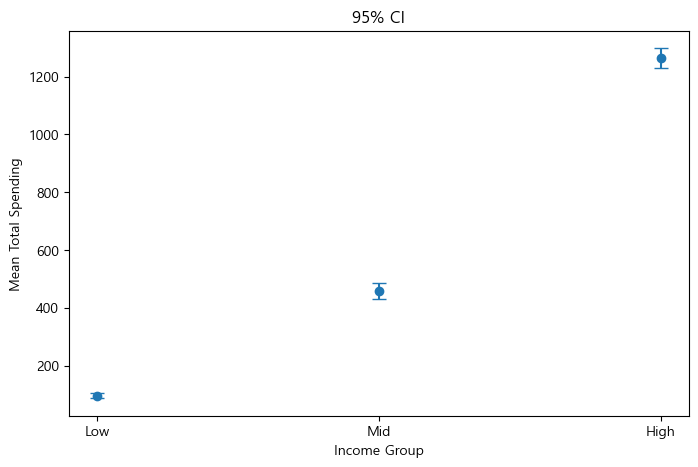

In [140]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프

groups = ['Low', 'Mid', 'High']

means = []
errors = []

for g in groups:
    data = df[df['Income_Group'] == g]['Total_Spending']
    
    x_bar = data.mean()
    s = data.std(ddof=1)
    n = len(data)
    se = s / np.sqrt(n)
    
    t_crit = t.ppf(0.975, df=n-1)
    margin = t_crit * se
    
    means.append(x_bar)
    errors.append(margin)

plt.figure(figsize=(8,5))

plt.errorbar(groups, means, yerr=errors, fmt='o', capsize=5)

plt.title("95% CI")
plt.xlabel("Income Group")
plt.ylabel("Mean Total Spending")

plt.show()


### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [145]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력

from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(no_child, yes_child, equal_var=False)

print("="*60)
print("Welch's t-test 결과")
print("="*60)
print(f"t-statistic = {t_stat}")
print(f"p-value = {p_value}")


mean1, mean2 = no_child.mean(), yes_child.mean()
std1, std2 = no_child.std(ddof=1), yes_child.std(ddof=1)
n1, n2 = len(no_child), len(yes_child)


pooled_sd = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))

cohens_d = (mean1 - mean2) / pooled_sd

print(f"\nCohen's d = {cohens_d}")


print(f"효과크기 해석: Cohen's d 값이 약 1.36으로 0.8보다 크기 때문에 큰 효과이다.")


Welch's t-test 결과
t-statistic = 24.98885267929026
p-value = 6.321230429385628e-105

Cohen's d = 1.3598537468445944
효과크기 해석: Cohen's d 값이 약 1.36으로 0.8보다 크기 때문에 큰 효과이다.


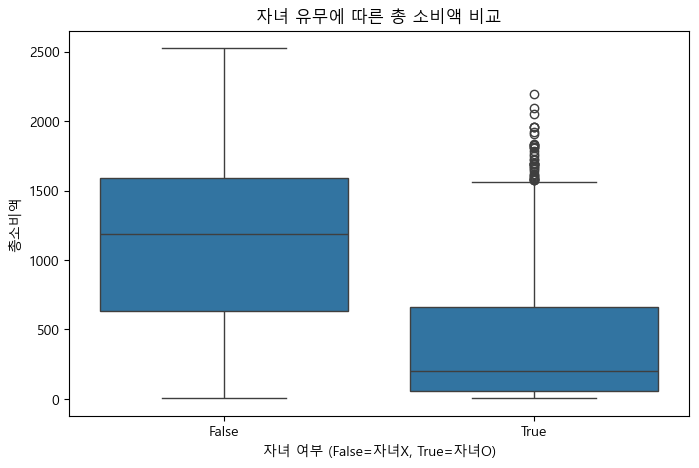

In [148]:
# TODO 3-2(c): 박스플롯 비교 시각화

plt.figure(figsize=(8,5))

sns.boxplot(x='Has_Children', y='Total_Spending', data=df)

plt.title("자녀 유무에 따른 총 소비액 비교")
plt.xlabel("자녀 여부 (False=자녀X, True=자녀O)")
plt.ylabel("총소비액")

plt.show()

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [154]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
from scipy.stats import ttest_rel

diff = wines - meat

t_stat, p_value = ttest_rel(wines, meat)

mean_diff = diff.mean()
std_diff = diff.std(ddof=1)

cohens_d = mean_diff / std_diff


print(f"t-statistic = {t_stat}")
print(f"p-value = {p_value}")
print(f"Cohen's d = {cohens_d}")

print("효과크기: Cohen's d 값이 0.49로 0.5보다 작으므로 작은 효과이다.")


t-statistic = 23.092889483443262
p-value = 5.391926544698085e-106
Cohen's d = 0.488362577872471
효과크기: Cohen's d 값이 0.49로 0.5보다 작으므로 작은 효과이다.


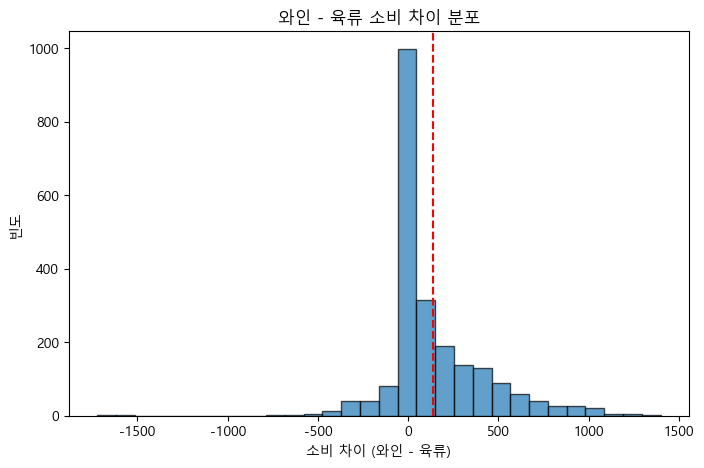

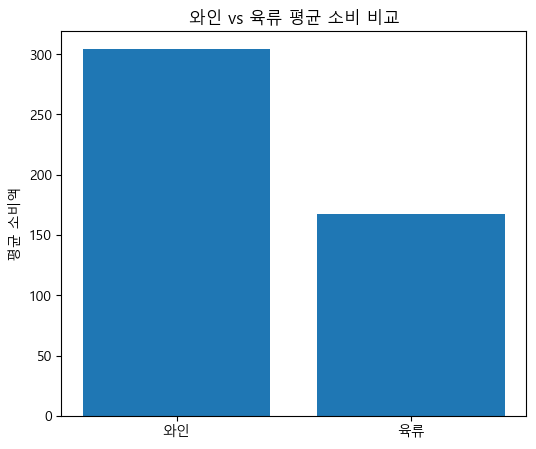

In [156]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프

plt.figure(figsize=(8,5))
plt.hist(diff, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(diff.mean(), color='red', linestyle='--')
plt.title("와인 - 육류 소비 차이 분포")
plt.xlabel("소비 차이 (와인 - 육류)")
plt.ylabel("빈도")
plt.show()


mean_wine = wines.mean()
mean_meat = meat.mean()

plt.figure(figsize=(6,5))
plt.bar(["와인", "육류"], [mean_wine, mean_meat])
plt.title("와인 vs 육류 평균 소비 비교")
plt.ylabel("평균 소비액")
plt.show()

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [159]:
power_analysis = TTestIndPower()

# TODO 3-4(a): 문제 3-2 기준 검정력 계산
alpha = 0.05
ratio = len(yes_child) / len(no_child)

power = power_analysis.solve_power(effect_size=cohens_d, nobs1=len(no_child), ratio=ratio, alpha=alpha, alternative='two-sided')
print(f"Power = {power}")


# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정
required_n = power_analysis.solve_power(effect_size=0.2, power=0.80, alpha=alpha, ratio=1.0, alternative='two-sided')
print(f"필요 표본 크기 ≈ {np.ceil(required_n)}")

Power = 1.0
필요 표본 크기 ≈ 394.0


---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [174]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)
from scipy.stats import shapiro
import scipy.stats as stats

for g in edu_groups:
    data = df[df['Education_Group'] == g]['Total_Spending']
    print(f"\n[{g}]")
    print("표본 크기:", len(data))
    
    stat, p = shapiro(data)
    
    print("Shapiro 통계량:", stat)
    print("p-value:", p)
    
    if p < 0.05:
        print("→ 정규성을 따르지 않음 (기각)")
    else:
        print("→ 정규성을 따름")



# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
use_welch = None

from scipy.stats import levene

group1 = df[df['Education_Group'] == 'Undergraduate']['Total_Spending']
group2 = df[df['Education_Group'] == 'Graduate']['Total_Spending']
group3 = df[df['Education_Group'] == 'Postgraduate']['Total_Spending']


stat, p = levene(group1, group2, group3)


print("\nLevene 통계량:", stat)
print("p-value:", p)

print("등분산 가정 위반 (Welch ANOVA 사용) → use_welch = True")





[Undergraduate]
표본 크기: 255
Shapiro 통계량: 0.7604908247215473
p-value: 5.543648052614619e-19
→ 정규성을 따르지 않음 (기각)

[Graduate]
표본 크기: 1126
Shapiro 통계량: 0.874298605350791
p-value: 3.561909628976696e-29
→ 정규성을 따르지 않음 (기각)

[Postgraduate]
표본 크기: 855
Shapiro 통계량: 0.8764736594870332
p-value: 1.7757879312718283e-25
→ 정규성을 따르지 않음 (기각)

Levene 통계량: 13.289295744619572
p-value: 1.8306692793099772e-06
등분산 가정 위반 (Welch ANOVA 사용) → use_welch = True


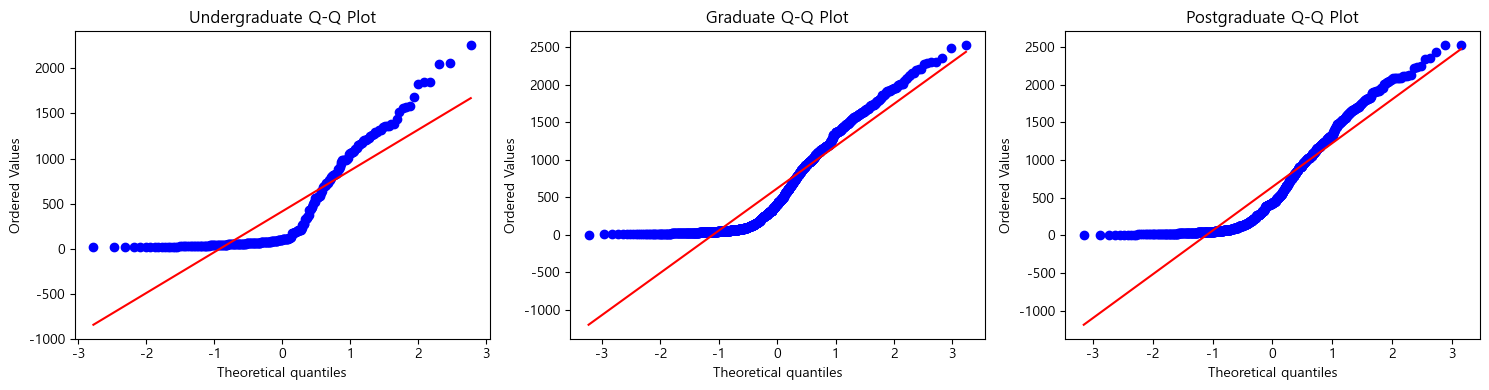

In [176]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)


plt.figure(figsize=(15,4))


data1 = df[df['Education_Group'] == 'Undergraduate']['Total_Spending']
plt.subplot(1, 3, 1)
stats.probplot(data1, dist="norm", plot=plt)
plt.title("Undergraduate Q-Q Plot")

data2 = df[df['Education_Group'] == 'Graduate']['Total_Spending']
plt.subplot(1, 3, 2)
stats.probplot(data2, dist="norm", plot=plt)
plt.title("Graduate Q-Q Plot")

data3 = df[df['Education_Group'] == 'Postgraduate']['Total_Spending']
plt.subplot(1, 3, 3)
stats.probplot(data3, dist="norm", plot=plt)
plt.title("Postgraduate Q-Q Plot")

plt.tight_layout()
plt.show()

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [181]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
import pingouin as pg
from scipy.stats import kruskal

welch = pg.welch_anova(dv='Total_Spending', between='Education_Group', data=df)

print("Welch's ANOVA 결과")
print(welch)


h_stat, p_value = kruskal(group_data['Undergraduate'], group_data['Graduate'], group_data['Postgraduate'])

print("\nKruskal-Wallis 검정 결과")
print("H 통계량:", h_stat)
print("p-value:", p_value)



# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)

all_data = df['Total_Spending'].values
k = len(edu_groups)
grand_mean = np.mean(all_data)
ss_between = 0

for g in edu_groups:
    group = group_data[g]
    ss_between += len(group) * (np.mean(group) - grand_mean) ** 2


ss_within = 0
for g in edu_groups:
    group = group_data[g]
    ss_within += np.sum((group - np.mean(group)) ** 2)


ss_total = ss_between + ss_within
df_between = k - 1
df_within = len(all_data) - k
ms_within = ss_within / df_within


eta_squared = ss_between / ss_total
omega_squared = (ss_between - df_between * ms_within) / (ss_total + ms_within)

print("\n효과크기")
print("η² =", eta_squared)
print("ω² =", omega_squared)


print("η² 값이 약 0.01로 0.06보다 작으므로 중간 효과")


Welch's ANOVA 결과
            Source  ddof1       ddof2          F         p-unc     np2
0  Education_Group      2  751.708152  19.817377  4.098696e-09  0.0137

Kruskal-Wallis 검정 결과
H 통계량: 36.61332315890714
p-value: 1.1207736037427136e-08

효과크기
η² = 0.013700282366187278
ω² = 0.01281123840913708
η² 값이 약 0.01로 0.06보다 작으므로 중간 효과


In [187]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g

gh = pg.pairwise_gameshowell(dv='Total_Spending', between='Education_Group', data=df)

print("Games-Howell 사후검정 결과")
print(gh)

pairs = [('Undergraduate','Graduate'), ('Undergraduate','Postgraduate'), ('Graduate','Postgraduate')]

print("\n쌍별 효과크기 (Hedges'g)")
for g1, g2 in pairs:
    
    data1 = group_data[g1]
    data2 = group_data[g2]
    
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    
    sd1 = np.std(data1, ddof=1)
    sd2 = np.std(data2, ddof=1)
    
    n1 = len(data1)
    n2 = len(data2)
    
    pooled_sd = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2) / (n1+n2-2))
    d = (mean1 - mean2) / pooled_sd
    
    correction = 1 - (3 / (4*(n1+n2) - 9))
    g = d * correction

    print(f"{g1} vs {g2} : {g}")
    
    if abs(g) < 0.2:
        print("매우 작은 효과")
    elif abs(g) < 0.5:
        print("작은 효과")
    elif abs(g) < 0.8:
        print("중간 효과")
    else:
        print("큰 효과")

Games-Howell 사후검정 결과
              A              B     mean(A)     mean(B)        diff         se  \
0      Graduate   Postgraduate  620.394316  644.791813  -24.397497  27.691976   
1      Graduate  Undergraduate  620.394316  412.254902  208.139414  36.852786   
2  Postgraduate  Undergraduate  644.791813  412.254902  232.536911  38.554847   

          T           df          pval    hedges  
0 -0.881031  1808.339544  6.523632e-01 -0.040121  
1  5.647861   425.032927  8.920656e-08  0.355688  
2  6.031328   492.811108  9.577128e-09  0.389636  

쌍별 효과크기 (Hedges'g)
Undergraduate vs Graduate : -0.3556877389238542
작은 효과
Undergraduate vs Postgraduate : -0.3896358072281582
작은 효과
Graduate vs Postgraduate : -0.04012144041389733
매우 작은 효과


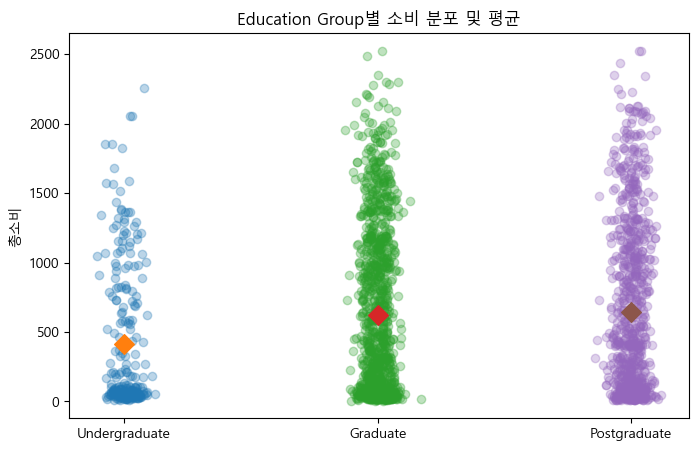

In [190]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드

plt.figure(figsize=(8,5))


groups = ['Undergraduate', 'Graduate', 'Postgraduate']

data1 = group_data['Undergraduate']
x1 = np.random.normal(0, 0.04, len(data1))
plt.scatter(x1, data1, alpha=0.3)
mean1 = np.mean(data1)
plt.scatter(0, mean1, marker='D', s=100)

data2 = group_data['Graduate']
x2 = np.random.normal(1, 0.04, len(data2))
plt.scatter(x2, data2, alpha=0.3)
mean2 = np.mean(data2)
plt.scatter(1, mean2, marker='D', s=100)

data3 = group_data['Postgraduate']
x3 = np.random.normal(2, 0.04, len(data3))
plt.scatter(x3, data3, alpha=0.3)
mean3 = np.mean(data3)
plt.scatter(2, mean3, marker='D', s=100)


plt.xticks([0,1,2], groups)
plt.ylabel("총소비")
plt.title("Education Group별 소비 분포 및 평균")

plt.show()

### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [199]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])
print(crosstab_no_margin)

from scipy.stats import chi2_contingency
from math import sqrt, log, exp

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
chi2, p, dof, expected = chi2_contingency(crosstab_no_margin)
print("\n카이제곱 검정 결과")
print("χ² 통계량:", chi2)
print("p-value:", p)
print("자유도:", dof)

expected_flat = expected.flatten()
small_cells = np.sum(expected_flat < 5)
total_cells = len(expected_flat)

print("\n기대빈도 < 5 셀 개수:", small_cells)
print("전체 셀 개수:", total_cells)
print(small_cells / total_cells)

print("Cochran 규칙 충족")

# TODO 4-3(b): φ (phi) 계산
n = crosstab_no_margin.values.sum()
phi = sqrt(chi2 / n)

print("\n효과크기 φ =", phi)
print("매우 작은 효과")



# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산

a = crosstab_no_margin.iloc[0,0]
b = crosstab_no_margin.iloc[0,1]
c = crosstab_no_margin.iloc[1,0]
d = crosstab_no_margin.iloc[1,1]

OR = (a * d) / (b * c)

SE = sqrt(1/a + 1/b + 1/c + 1/d)
lower = exp(log(OR) - 1.96 * SE)
upper = exp(log(OR) + 1.96 * SE)

print("\n오즈비(Odds Ratio) =", OR)
print("95% CI =", (lower, upper))

Campaign_Response  False  True 
Marital_Group                  
Single               547    247
Together            1081    361

카이제곱 검정 결과
χ² 통계량: 9.236758434275565
p-value: 0.002372044985880111
자유도: 1

기대빈도 < 5 셀 개수: 0
전체 셀 개수: 4
0.0
Cochran 규칙 충족

효과크기 φ = 0.06427230766297097
매우 작은 효과

오즈비(Odds Ratio) = 0.7395573898811642
95% CI = (0.6105091394613098, 0.8958836118496832)


Campaign_Response     False     True 
Marital_Group                        
Single             0.688917  0.311083
Together           0.749653  0.250347


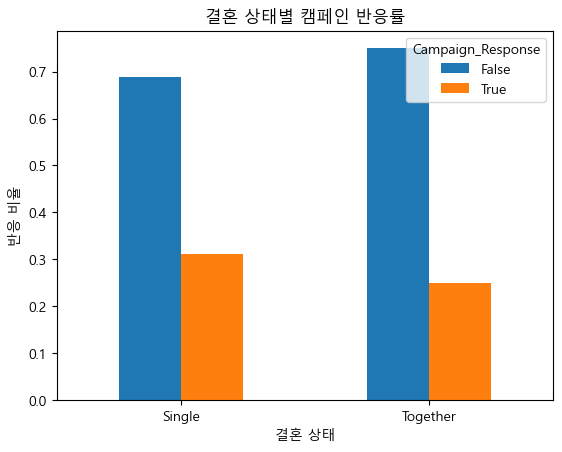

In [202]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵

#(1) 결혼 상태별 반응률 막대그래프

response_rate = crosstab_no_margin.div(crosstab_no_margin.sum(axis=1), axis=0)
print(response_rate)

response_rate.plot(kind='bar')
plt.title("결혼 상태별 캠페인 반응률")
plt.ylabel("반응 비율")
plt.xlabel("결혼 상태")
plt.xticks(rotation=0)
plt.show()

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [215]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values
from scipy.stats import chisquare

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
total = observed.sum()
expected = np.array([total/3, total/3, total/3])
print(f"\n기대빈도 (균등) :", expected)

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print("\n카이제곱 적합도 검정")
print("χ² 통계량:", chi2_stat)
print("p-value:", p_value)

# TODO 4-4(b): Cohen's w 계산

obs = observed / observed.sum()
exp = np.array([1/3, 1/3, 1/3])

w = np.sqrt(np.sum((obs - exp)**2 / exp))

print("\nCohen's w =", w)



기대빈도 (균등) : [9351.33333333 9351.33333333 9351.33333333]

카이제곱 적합도 검정
χ² 통계량: 2630.1062950024952
p-value: 0.0

Cohen's w = 0.3061887670972693


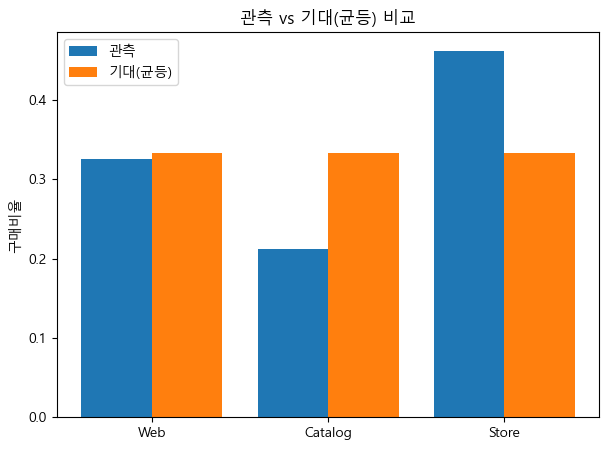

In [218]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프

observed_ratio = observed / observed.sum()
expected_ratio = np.array([1/3, 1/3, 1/3])

x = np.arange(len(channel_names))

plt.figure(figsize=(7,5))
plt.bar(x - 0.2, observed_ratio, width=0.4, label="관측")
plt.bar(x + 0.2, expected_ratio, width=0.4, label="기대(균등)")
plt.xticks(x, channel_names)
plt.ylabel("구매비율")
plt.title("관측 vs 기대(균등) 비교")
plt.legend()
plt.show()

---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [225]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산
data = df[corr_vars]

pearson_corr = data.corr(method='pearson')
spearman_corr = data.corr(method='spearman')

print("Pearson 상관행렬 : \n", pearson_corr)
print("\nSpearman 상관행렬 : \n", spearman_corr)


# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)

pairs = [
    ('Income', 'Total_Spending'),
    ('Income', 'Total_Purchases'),
    ('Age', 'Total_Spending'),
    ('NumWebVisitsMonth', 'Total_Purchases'),
    ('Recency', 'Total_Spending')
]

for var1, var2 in pairs:
    
    r, p = stats.pearsonr(df[var1], df[var2])
    
    print(f"\n{var1} vs {var2}")
    print("상관계수 r =", r)
    print("p-value =", p)

Pearson 상관행렬 : 
                      Income       Age  Total_Spending  Total_Purchases  \
Income             1.000000  0.198835        0.789375         0.738647   
Age                0.198835  1.000000        0.113618         0.173004   
Total_Spending     0.789375  0.113618        1.000000         0.821091   
Total_Purchases    0.738647  0.173004        0.821091         1.000000   
NumWebVisitsMonth -0.646382 -0.117498       -0.499909        -0.426734   
Recency            0.007829  0.019396        0.020842         0.006426   

                   NumWebVisitsMonth   Recency  
Income                     -0.646382  0.007829  
Age                        -0.117498  0.019396  
Total_Spending             -0.499909  0.020842  
Total_Purchases            -0.426734  0.006426  
NumWebVisitsMonth           1.000000 -0.021850  
Recency                    -0.021850  1.000000  

Spearman 상관행렬 : 
                      Income       Age  Total_Spending  Total_Purchases  \
Income             1.000000 

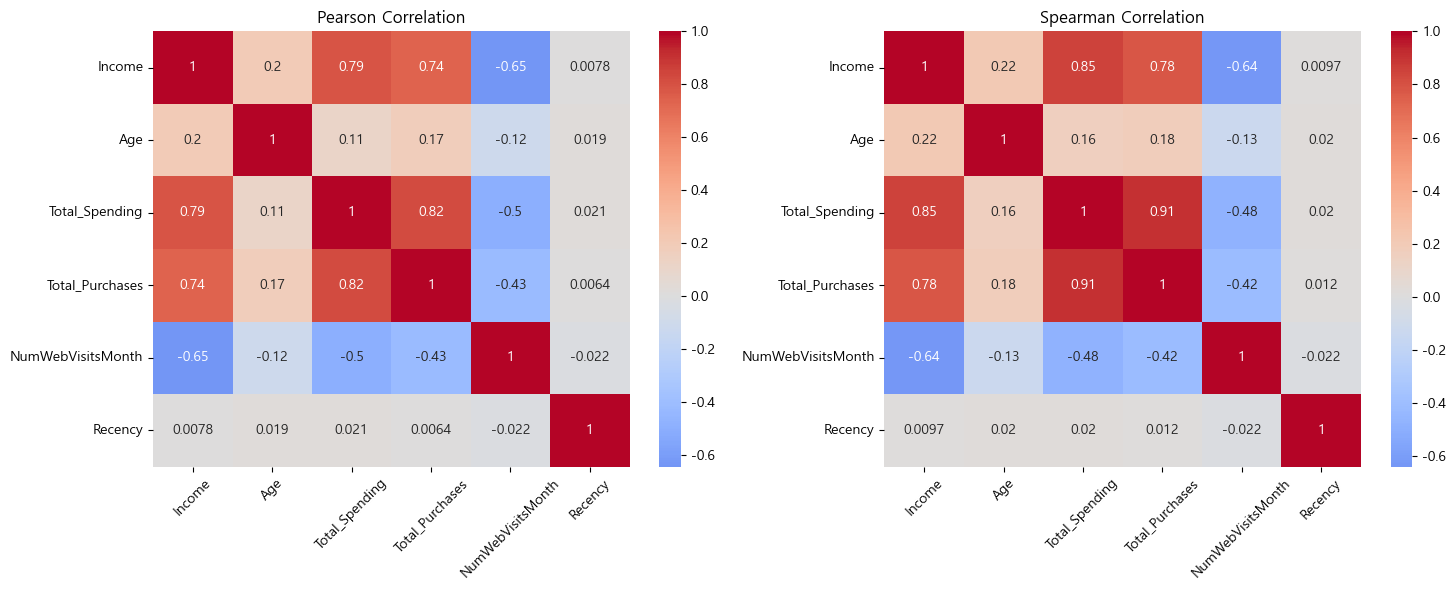

In [235]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', center=0)
plt.title("Pearson Correlation")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0)
plt.title("Spearman Correlation")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


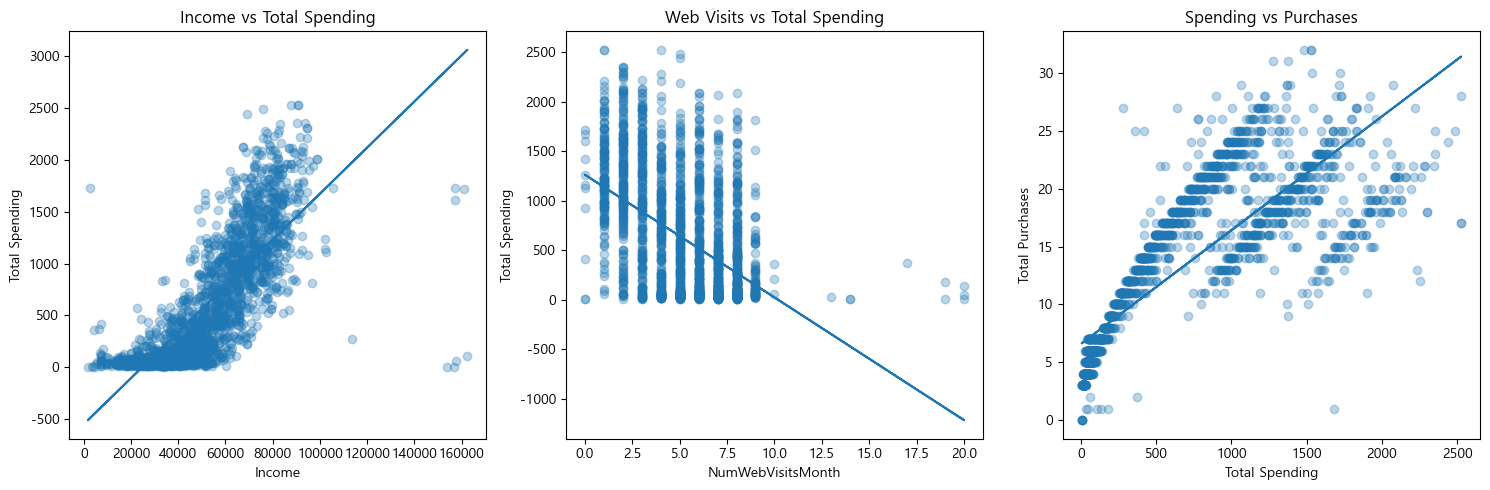

In [239]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요

plt.figure(figsize=(15,5))

x1 = df['Income']
y1 = df['Total_Spending']
plt.subplot(1, 3, 1)
plt.scatter(x1, y1, alpha=0.3)

coef1 = np.polyfit(x1, y1, 1)
poly1 = np.poly1d(coef1)
plt.plot(x1, poly1(x1))
plt.title("Income vs Total Spending")
plt.xlabel("Income")
plt.ylabel("Total Spending")

# --------------------------------------------

x2 = df['NumWebVisitsMonth']
y2 = df['Total_Spending']
plt.subplot(1, 3, 2)
plt.scatter(x2, y2, alpha=0.3)

coef2 = np.polyfit(x2, y2, 1)
poly2 = np.poly1d(coef2)
plt.plot(x2, poly2(x2))
plt.title("Web Visits vs Total Spending")
plt.xlabel("NumWebVisitsMonth")
plt.ylabel("Total Spending")


#----------------------------------------------

x3 = df['Total_Spending']
y3 = df['Total_Purchases']
plt.subplot(1, 3, 3)
plt.scatter(x3, y3, alpha=0.3)

coef3 = np.polyfit(x3, y3, 1)
poly3 = np.poly1d(coef3)
plt.plot(x3, poly3(x3))
plt.title("Spending vs Purchases")
plt.xlabel("Total Spending")
plt.ylabel("Total Purchases")


plt.tight_layout()
plt.show()


### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [242]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b

# TODO 5-2(a): z-비율검정
p_pool = (conv_a + conv_b) / (n_a + n_b)
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_a + 1/n_b))
z_stat = (rate_a - rate_b) / se
p_value = 2 * (1 - norm.cdf(abs(z_stat)))

print("z 통계량 =", z_stat)
print("p-value =", p_value)

# TODO 5-2(b): Cohen's h 효과 크기
h = 2 * (np.arcsin(np.sqrt(rate_a)) - np.arcsin(np.sqrt(rate_b)))
print("\nCohen's h =", h)

# TODO 5-2(c): Wilson 신뢰구간
z = norm.ppf(0.975)

# A 그룹
den_a = 1 + z**2 / n_a
center_a = (rate_a + z**2 / (2*n_a)) / den_a
margin_a = (z * np.sqrt((rate_a*(1-rate_a)/n_a) + (z**2/(4*n_a**2)))) / den_a
lower_a = center_a - margin_a
upper_a = center_a + margin_a

# B 그룹
den_b = 1 + z**2 / n_b
center_b = (rate_b + z**2 / (2*n_b)) / den_b
margin_b = (z * np.sqrt((rate_b*(1-rate_b)/n_b) + (z**2/(4*n_b**2)))) / den_b
lower_b = center_b - margin_b
upper_b = center_b + margin_b

print("\nWilson 95% 신뢰구간")
print(f"Group A: ({lower_a:.4f}, {upper_a:.4f})")
print(f"Group B: ({lower_b:.4f}, {upper_b:.4f})")

z 통계량 = -17.435692501112072
p-value = 0.0

Cohen's h = -0.8016212123405796

Wilson 95% 신뢰구간
Group A: (0.0704, 0.0960)
Group B: (0.3631, 0.4523)


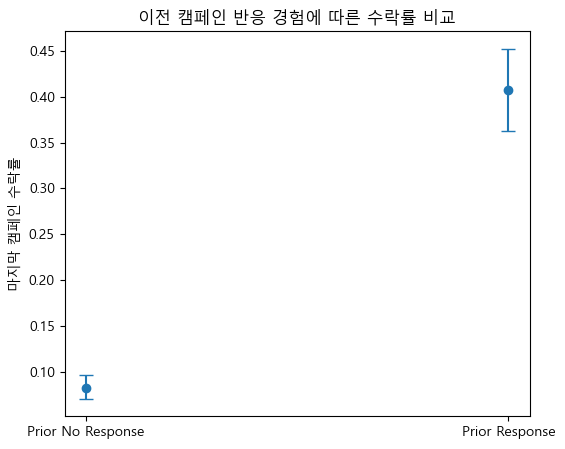

In [244]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)

groups = ['Prior No Response', 'Prior Response']
rates = [rate_a, rate_b]


errors = [
    [rate_a - lower_a, rate_b - lower_b],
    [upper_a - rate_a, upper_b - rate_b]
]

plt.figure(figsize=(6,5))
plt.errorbar(groups, rates, yerr=errors, fmt='o', capsize=5)
plt.title("이전 캠페인 반응 경험에 따른 수락률 비교")
plt.ylabel("마지막 캠페인 수락률")

plt.show()



> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [248]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산

h = 2 * (np.arcsin(np.sqrt(target_rate)) - np.arcsin(np.sqrt(baseline_rate)))
print("Cohen's h =", h)


# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)

power_analysis = NormalIndPower()

# 필요 표본 크기 계산 (단측검정)
required_n = power_analysis.solve_power(effect_size=h, alpha=0.05, power=0.80, alternative='larger')
print("필요 표본 크기(단측검정) =", np.ceil(required_n))

Cohen's h = 0.05466566903304804
필요 표본 크기(단측검정) = 4138.0


---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [ ]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [ ]:
# TODO C-2: 비즈니스 제안서 작성

---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛